In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns

In [29]:
rcParams['figure.figsize'] = 15, 5

In [4]:
plt.style.use('fivethirtyeight') # estilo dos gráficos

In [5]:
# load models forecasts
df = pd.DataFrame()
for file in os.listdir("validation"):
    file_name = "validation/" + file
    df2 = pd.read_csv(file_name, index_col = "date")
    df2.columns = [file[:-7]]
    df = pd.concat([df, df2], axis = 1)

In [6]:
# load "actual" data
test = train_test_split(load_data(), 31)[1]
test.index = df.index
test.columns = ["test"]

In [7]:
df2 = pd.concat([df, test], axis = 1)
df2.head(3)

,auto_arima,decision_trees,lightgbm,prophet,xgboost,test
date,,,,,,
2022-05-01,9199.879992,8918.050667,8803.036033,9779.973297,8924.021484,8794.163125
2022-05-02,12129.336925,10351.305465,11388.489043,12001.221303,11855.990234,11643.821542
2022-05-03,12613.390092,10842.369542,11802.404352,12332.062222,11673.096680,11941.662583


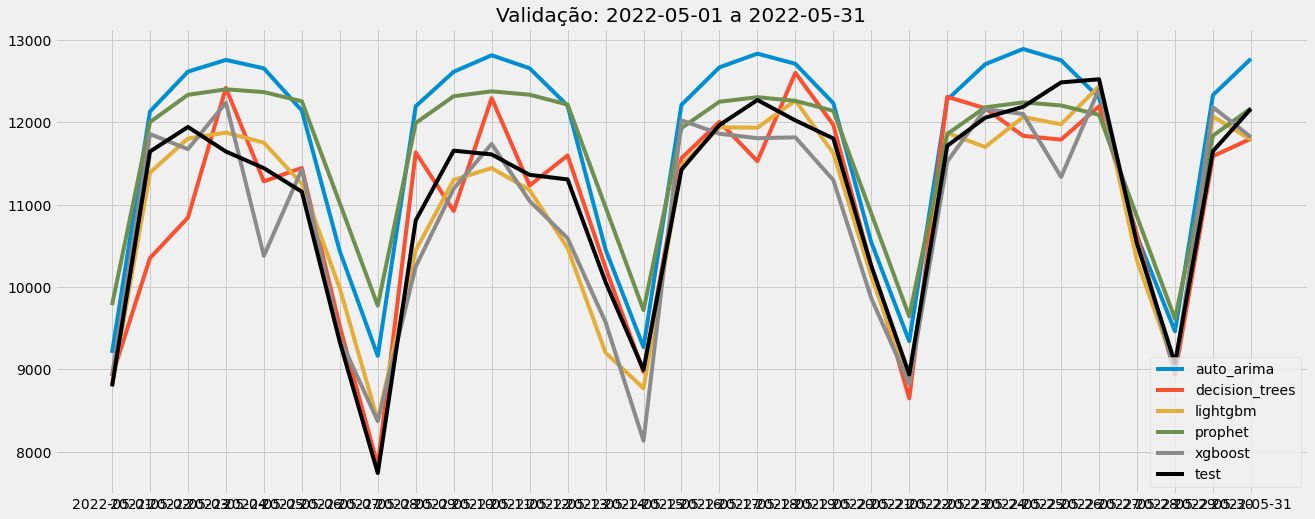

In [30]:
plt.figure(figsize = (20,8))

for model in df2.columns:
    if model == "test":
        continue
    plt.plot(df2[model], label = model)

plt.plot(df2["test"], c = "black", label = "test")

date_init = df2.index[0]
date_end = df2.index[-1]
plt.title(f"Validação: {date_init} a {date_end}")
plt.legend(loc = "lower right")

plt.show()

In [31]:
df3 = df2.reset_index().melt(id_vars = "date")
px.line(df3, x = "date", y = "value", color= "variable", title=f"Validação: {date_init} a {date_end}")

### Medidas de acurácia

In [8]:
dict_metrics = []
for model in df2.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df2[model], df2["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df2_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]

In [47]:
df2_metrics

,model,erro,mae,mse,rmse,mape,smape
0,auto_arima,1.940707e+07,703.8002,626034.5276,791.2234,0.0648,6.2193
1,decision_trees,7.720546e+06,373.8243,249049.8674,499.0490,0.0327,3.2938
2,lightgbm,3.894151e+06,279.1693,125617.7876,354.4260,0.0260,2.6147
3,prophet,1.851867e+07,618.5224,597376.3715,772.9013,0.0607,5.7684
4,xgboost,7.073865e+06,380.3791,228189.1919,477.6915,0.0348,3.5340


In [45]:
df3_metrics = df2_metrics.melt(id_vars = "model", var_name="metric")
df3_metrics["metric_ranking"] = df3_metrics.groupby(["metric"])["value"].rank("first")
df3_metrics.sort_values(by = ["metric", "metric_ranking"], inplace = True)

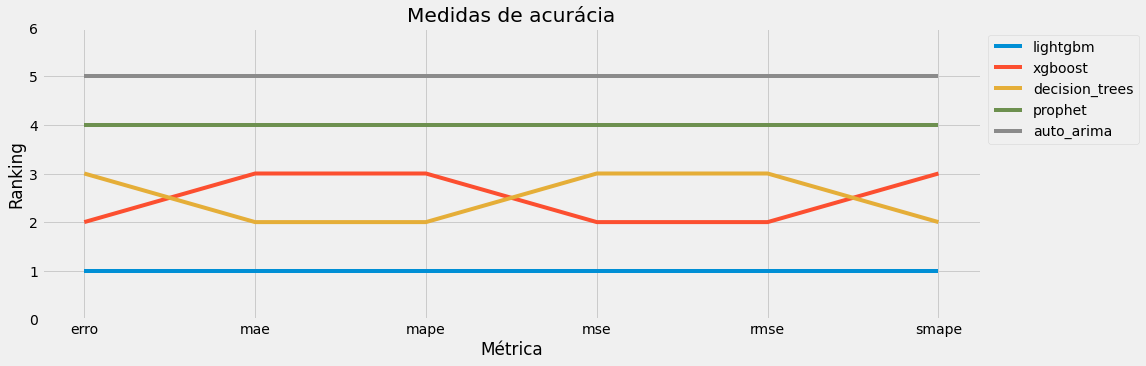

In [49]:
plt.figure()

ax = sns.lineplot(data=df3_metrics, x = "metric", y = "metric_ranking", hue="model")
ax.legend(bbox_to_anchor = (1,1))

plt.ylim(0, (df3_metrics["metric_ranking"].max()+1))
plt.ylabel("Ranking")
plt.xlabel("Métrica")
plt.title("Medidas de acurácia")
plt.show()